# Head direction attractor network


### Table of contents

1. [**Likelihood**](#likelihood)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()

<a id="likelihood"></a>
## Likelihood functions

In [2]:
likelihood_type = 'ZIP'# 'NB', 'ZIP', 'P'

In [4]:
neurons = 1
tbin = 0.1

### count process output ###
if likelihood_type == 'NB':
    r_inv = 0.0*torch.ones(neurons)
    likelihood = nprb.likelihoods.Negative_binomial(tbin, neurons, 'exp', r_inv)
elif likelihood_type == 'ZIP':
    alpha = 0.95*torch.ones(neurons)
    likelihood = nprb.likelihoods.ZI_Poisson(tbin, neurons, 'exp', alpha)
elif likelihood_type == 'CMP':
    log_nu = 1.*torch.ones(neurons)
    likelihood = nprb.likelihoods.COM_Poisson(tbin, neurons, 'exp', log_nu)
elif likelihood_type == 'P':
    likelihood = nprb.likelihoods.Poisson(tbin, neurons, 'exp')

### set data ###
max_count = 10
spikes = torch.arange(max_count)[None, :]
likelihood.set_Y(spikes, max_count)

### compute NLL ###
trials = 2
rates = 10.0*torch.ones(trials, neurons, max_count) # primary parameter
#disper_param = 0.1*torch.ones(trials, neurons, max_count) # dispersion parameter
nll = likelihood.nll(0, rates, spikes*torch.log(rates), spikes, range(neurons))#, disper_param=disper_param)

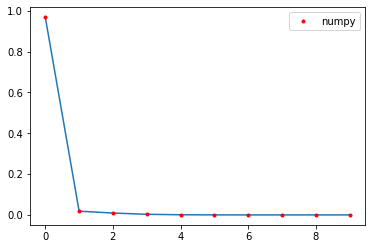

In [5]:
plt.plot(spikes[0, :], np.exp(-nll.data.numpy()[0, :]))
bins = np.arange(max_count)

if likelihood_type == 'NB':
    prbs = utils.stats.nb_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), r_inv[0].item(), 1.0)
elif likelihood_type == 'ZIP':
    prbs = utils.stats.zip_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), alpha[0].item(), 1.0)
elif likelihood_type == 'CMP':
    prbs = utils.stats.cmp_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), np.exp(log_nu[0].item()), 1.0)
elif likelihood_type == 'P':
    prbs = utils.stats.poiss_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), None, 1.0)
    
plt.plot(bins, prbs, 'r.', label=r'numpy')
plt.legend()
plt.show()

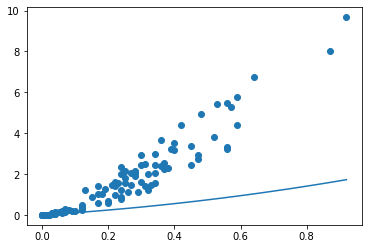

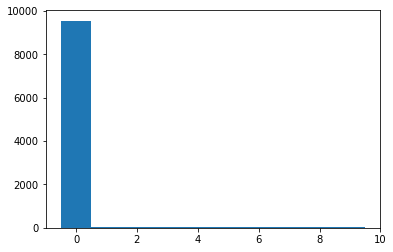

In [6]:
### sample ###
rate = np.linspace(0, 10, 100)[None, None, :].repeat(100, axis=0)*10
syn_train = likelihood.sample(rate, [0], XZ=None)


### empirical count mean and variance ###
m = syn_train.mean(0)
v = syn_train.var(0)

plt.scatter(m, v)

nx = np.linspace(0, m.max())
plt.plot(nx, nx*(1+nx*alpha.numpy()[0]))
plt.show()

plt.hist(syn_train.flatten(), bins=np.arange(max_count+1)-.5)
plt.show()

In [8]:
### rebinning ###
bin_size = 100
rc_ts = []

for k in range(100):
    tbin, resamples, rc_t, _ = utils.neural.bin_data(bin_size, sample_bin, syn_train[k], 
                                                            syn_train.shape[-1], (), average_behav=False, binned=True)
    rc_ts.append(rc_t)
    
rc_ts = np.array(rc_ts)

NameError: name 'sample_bin' is not defined

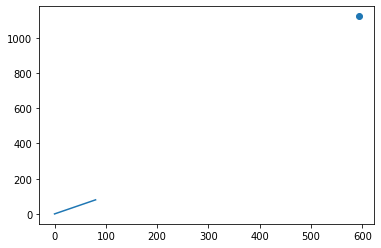

In [85]:
mean_act = (rc_ts).mean(0)
var_act = (rc_ts).var(0)

plt.scatter(mean_act, var_act)
nx = np.linspace(0, 80)
plt.plot(nx, nx*(1+nx*r_inv.numpy()[0]))
plt.show()